## In this notebook I have covered three models 
#### Logistic Regression
#### Decision Tree
#### Naive Bayes

After pre-processing the data, I have used stemming and lemmatization to normalize the data
and also Feature Extrction using  CountVectorizer and TfidfVectorizer

The dataset used is from kaggle - https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

I have also used examples from Live Customer interactions's with ChatBot application.

The Kaggle dataset contains 6 different concent moderation categories -
toxic,	severe_toxic,	obscene	threat,	insult,	identity_hate

I have created the model for identity_hate. 
Using identity_hate class helped in using the Real World data, as that data is tagged manually by our customer care 
representatives for this class making it available for evaluating the perforamnce of the model

    


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wordcloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

In [152]:
train_table = pd.read_csv('data/train.csv')

In [153]:
train_table.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159776.000000,159776.000000,159776.000000,159776.000000,159776.000000,159776.000000
mean,0.095722,0.009983,0.052880,0.002992,0.049300,0.010077
std,0.294210,0.099414,0.223795,0.054615,0.216495,0.099876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [154]:
# Filtering only Identity Hate
df = train_table.query('identity_hate != 0')
df_n = train_table.query('identity_hate == 0')

In [155]:
df_class_count = df
train_tags = df_class_count.drop(['id', 'comment_text'], axis = 1)
label_counts = train_tags.sum()
df_class_count = pd.DataFrame(label_counts)
df_class_count.rename(columns = {0:'counts'}, inplace = True)
df_class_count = df_class_count.sort_values('counts', ascending = False)
df_class_count

,counts
identity_hate,1610
toxic,1302
insult,1160
obscene,1032
severe_toxic,313
threat,98


In [156]:
df = df.append(df_n[:2500])

In [157]:
df.head(4)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
42,001810bf8c45bf5f,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!",1,0,1,0,1,1
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
176,006b94add72ed61c,I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms,1,0,1,1,1,1
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others have said this.. should this be included? That racists sometimes say these.",1,0,1,0,1,1


In [158]:
comment = df['comment_text']


In [159]:
import re

def text_preprocessing(text):
    #lower case
    text = text.lower()
    
    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)
    
    #pattern = (zero or more character)
    text = re.sub('\(.*?\)', '', text)
    
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #pattern = @some characters + space
    text = re.sub(r'(@.*?)[\s]', ' ', text) 
    
    #pattern = space+@+A-Za-z0-9_
    text = re.sub(r'\s([@][\w_-]+)', '', text).strip()
    
    #pattern = &amp
    text = re.sub(r'&amp;', '&', text)
    
    #pattern = multiple space
    text = re.sub(r'\s+', ' ', text).strip()
    
    #replace #
    text = text.replace("#" , " ")
    
    #pattern = any new line
    text = re.sub('\n', '', text)
    
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [160]:
df['processed_text'] = comment.apply(str).apply(lambda x: text_preprocessing(x))
df['processed_text_length'] = df['processed_text'].apply(lambda x:len(x))

In [161]:
df.head(4)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_text,processed_text_length
42,001810bf8c45bf5f,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!",1,0,1,0,1,1,"you are gay or antisemmitian? archangel white tiger meow! greetingshhh! uh, there are two ways, why you do erased my comment about ww2, that holocaust was brutally slaying of jews and not gays/gypsys/slavs/anyone... 1 - if you are anti-semitian, than shave your head bald and go to the skinhead meetings! 2 - if you doubt words of the bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals! 3 - first and last warning, you fucking gay - i won't appreciate if any more nazi shwain would write in my page! i don't wish to talk to you anymore! beware of the dark side!",640
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1,a pair of jew-hating weiner nazi schmucks.,42
176,006b94add72ed61c,I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms,1,0,1,1,1,1,i think that your a fagget get a oife and burn in hell i hate you 'm sorry we cant have any more sex i'm running out of conndoms,128
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others have said this.. should this be included? That racists sometimes say these.",1,0,1,0,1,1,"kill all niggers. i have hard, that others have said this.. should this be included? that racists sometimes say these.",118


In [162]:
df1 = df[['processed_text','identity_hate']]

In [163]:
df1.head(4)

,processed_text,identity_hate
42,"you are gay or antisemmitian? archangel white tiger meow! greetingshhh! uh, there are two ways, why you do erased my comment about ww2, that holocaust was brutally slaying of jews and not gays/gypsys/slavs/anyone... 1 - if you are anti-semitian, than shave your head bald and go to the skinhead meetings! 2 - if you doubt words of the bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals! 3 - first and last warning, you fucking gay - i won't appreciate if any more nazi shwain would write in my page! i don't wish to talk to you anymore! beware of the dark side!",1
105,a pair of jew-hating weiner nazi schmucks.,1
176,i think that your a fagget get a oife and burn in hell i hate you 'm sorry we cant have any more sex i'm running out of conndoms,1
218,"kill all niggers. i have hard, that others have said this.. should this be included? that racists sometimes say these.",1


In [164]:
pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes'], 
              'preprocessor': ['', '', ''],
             'best_params': ['', '', ''],
              'best_time': ['', '', ''],
             'best_score': ['', '', '']}).set_index('model')

,preprocessor,best_params,best_time,best_score
model,,,,
Logistic,,,,
Decision Tree,,,,
Bayes,,,,


In [165]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aaswal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aaswal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/aaswal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/aaswal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [166]:
#creating lemma and stemmer functions
def stemmer(text):
    stem = PorterStemmer()
    return ' '.join([stem.stem(w) for w in word_tokenize(text)])


def lemma(text):
    lema = WordNetLemmatizer()
    return ' '.join([lema.lemmatize(w) for w in word_tokenize(text)])

In [167]:
#created stemmed and lematixed columns in df

df1["txt_lemma"]  =  df1['processed_text'].apply(lemma)
df1["txt_stem"]  =  df1['processed_text'].apply(stemmer)

In [168]:
df1.head()

,processed_text,identity_hate,txt_lemma,txt_stem
42,"you are gay or antisemmitian? archangel white tiger meow! greetingshhh! uh, there are two ways, why you do erased my comment about ww2, that holocaust was brutally slaying of jews and not gays/gypsys/slavs/anyone... 1 - if you are anti-semitian, than shave your head bald and go to the skinhead meetings! 2 - if you doubt words of the bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals! 3 - first and last warning, you fucking gay - i won't appreciate if any more nazi shwain would write in my page! i don't wish to talk to you anymore! beware of the dark side!",1,"you are gay or antisemmitian ? archangel white tiger meow ! greetingshhh ! uh , there are two way , why you do erased my comment about ww2 , that holocaust wa brutally slaying of jew and not gays/gypsys/slavs/anyone ... 1 - if you are anti-semitian , than shave your head bald and go to the skinhead meeting ! 2 - if you doubt word of the bible , that homosexuality is a deadly sin , make a pentagram tatoo on your forehead go to the satanistic mass with your gay pal ! 3 - first and last warning , you fucking gay - i wo n't appreciate if any more nazi shwain would write in my page ! i do n't wish to talk to you anymore ! beware of the dark side !","you are gay or antisemmitian ? archangel white tiger meow ! greetingshhh ! uh , there are two way , whi you do eras my comment about ww2 , that holocaust wa brutal slay of jew and not gays/gypsys/slavs/anyon ... 1 - if you are anti-semitian , than shave your head bald and go to the skinhead meet ! 2 - if you doubt word of the bibl , that homosexu is a deadli sin , make a pentagram tatoo on your forehead go to the satanist mass with your gay pal ! 3 - first and last warn , you fuck gay - i wo n't appreci if ani more nazi shwain would write in my page ! i do n't wish to talk to you anymor ! bewar of the dark side !"
105,a pair of jew-hating weiner nazi schmucks.,1,a pair of jew-hating weiner nazi schmuck .,a pair of jew-hat weiner nazi schmuck .
176,i think that your a fagget get a oife and burn in hell i hate you 'm sorry we cant have any more sex i'm running out of conndoms,1,i think that your a fagget get a oife and burn in hell i hate you 'm sorry we cant have any more sex i 'm running out of conndoms,i think that your a fagget get a oif and burn in hell i hate you 'm sorri we cant have ani more sex i 'm run out of conndom
218,"kill all niggers. i have hard, that others have said this.. should this be included? that racists sometimes say these.",1,"kill all nigger . i have hard , that others have said this .. should this be included ? that racist sometimes say these .","kill all nigger . i have hard , that other have said thi .. should thi be includ ? that racist sometim say these ."
238,u r a tw fuck off u gay boy.u r smelly.fuck ur mum poopie,1,u r a tw fuck off u gay boy.u r smelly.fuck ur mum poopie,u r a tw fuck off u gay boy.u r smelly.fuck ur mum poopi


In [169]:
#Check for class imbalance
df1.identity_hate.value_counts(normalize = True)

0    0.608273
1    0.391727
Name: identity_hate, dtype: float64

<AxesSubplot:>

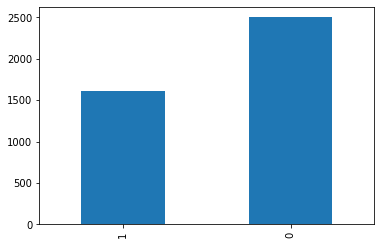

In [170]:
df1.identity_hate.value_counts().sort_values().plot(kind = 'bar')


## Visualize Word Frequency
## Used wordcloud library to visualize commonly used words as below:

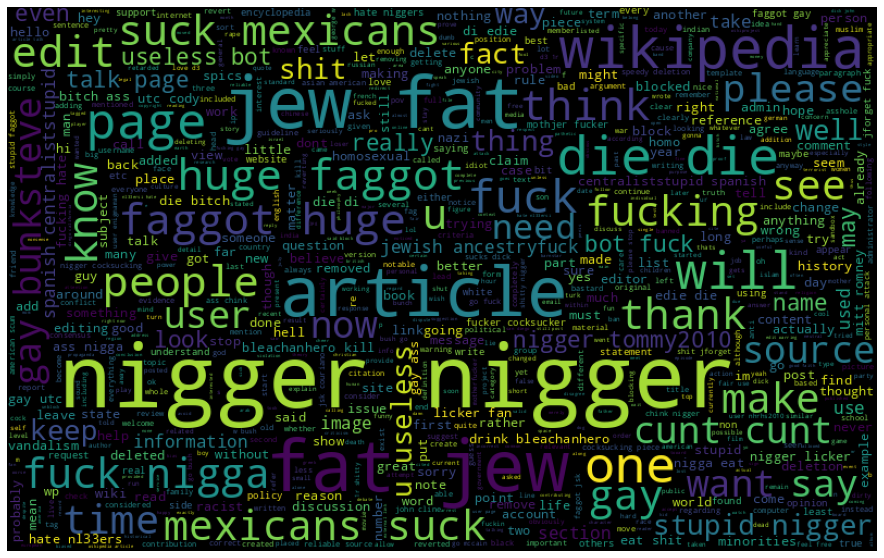

In [171]:
plt.subplots(figsize=(16,10))
wc = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=2000,
                      width = 800, height = 500,
                      background_color='black').generate(' '.join(t for t in df1['processed_text']))
plt.axis('off')
plt.imshow(wc)
plt.show()

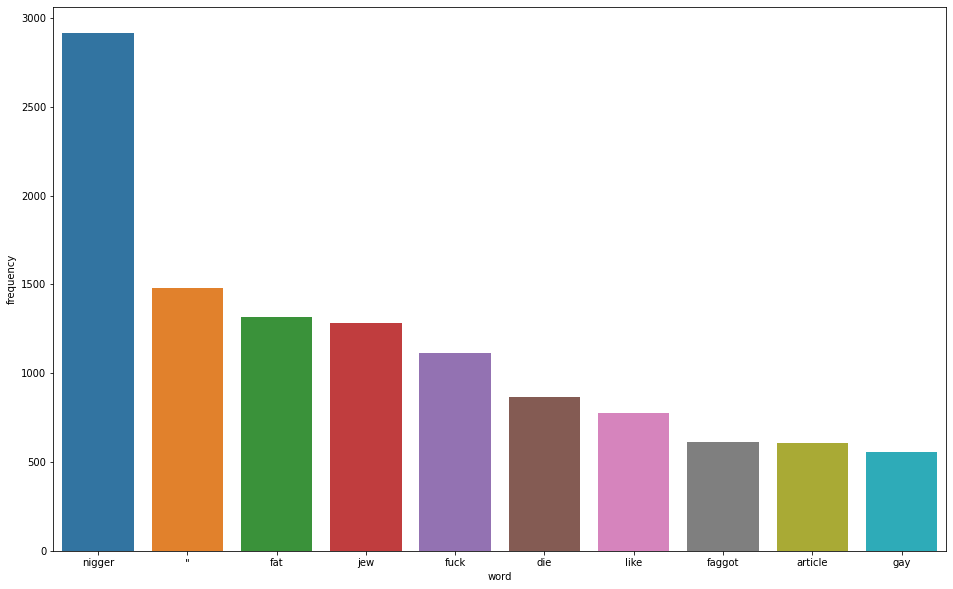

In [172]:
# Word frequency
stop = stopwords.words('english')
freq = df1['processed_text'].str.lower().str.split(expand=True).stack().value_counts().rename_axis('word'). \
    reset_index(name='frequency')
freq = freq[~freq['word'].str.lower().isin(stop)]
# Top 10 words
plt.subplots(figsize=(16,10))
sns.barplot(data=freq[0:10], x='word', y='frequency')
plt.show()

In [173]:
#Train/Test split
y = df1['identity_hate']
X = df1.drop('identity_hate',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

## CountVectorizer 

In [174]:
params = {'cvect__max_features': [100, 500, 1000, 2000],
         'cvect__stop_words': ['english', None]}
#Logistic Regression
vect_pipe_lr = Pipeline([('cvect', CountVectorizer()),
                       ('lgr', LogisticRegression())])
grid_lr = GridSearchCV(vect_pipe_lr, param_grid=params)
grid_lr.fit(X_train['processed_text'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('lgr', LogisticRegression())]),
             param_grid={'cvect__max_features': [100, 500, 1000, 2000],
                         'cvect__stop_words': ['english', None]})

In [175]:
lr_test_acc = grid_lr.score(X_test['processed_text'], y_test)
lr_train_acc = grid_lr.score(X_train['processed_text'], y_train)
lr_best_params = grid_lr.best_params_
lr_train_time  = np.sum(grid_lr.cv_results_["mean_fit_time"])

In [176]:
print(f'LR Train Accuracy - ',lr_train_acc )
print(f'LR Train Time - ',lr_train_time )
print(f'LR Test Accuracy - ',lr_test_acc )
print(f'LR Best params - ',lr_best_params )

LR Train Accuracy -  0.9341336794289422
LR Train Time -  1.2696341991424562
LR Test Accuracy -  0.8394941634241245
LR Best params -  {'cvect__max_features': 2000, 'cvect__stop_words': None}


In [177]:
#Naive Bayes
vect_pipe_nb = Pipeline([('cvect',CountVectorizer()),('nb',MultinomialNB())])
grid_nb = GridSearchCV(vect_pipe_nb,param_grid=params)
grid_nb.fit(X_train['processed_text'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvect__max_features': [100, 500, 1000, 2000],
                         'cvect__stop_words': ['english', None]})

In [178]:
nb_test_acc = grid_nb.score(X_test['processed_text'], y_test)
nb_train_acc = grid_nb.score(X_train['processed_text'], y_train)
nb_best_params = grid_nb.best_params_
nb_train_time  = np.sum(grid_nb.cv_results_["mean_fit_time"])

In [179]:
print(f'NB Train Accuracy - ',nb_train_acc )
print(f'NB Train Time - ',nb_train_time )
print(f'NB Test Accuracy - ',nb_test_acc )
print(f'NB Best params - ',nb_best_params )

NB Train Accuracy -  0.8737832576249189
NB Train Time -  0.819695234298706
NB Test Accuracy -  0.853112840466926
NB Best params -  {'cvect__max_features': 2000, 'cvect__stop_words': 'english'}


In [180]:
#Decision Tree
vect_pipe_dt = Pipeline([('cvect',CountVectorizer()),('dt',DecisionTreeClassifier(random_state=42))])
grid_dt = GridSearchCV(vect_pipe_dt,param_grid=params)
grid_dt.fit(X_train['processed_text'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'cvect__max_features': [100, 500, 1000, 2000],
                         'cvect__stop_words': ['english', None]})

In [182]:
dt_test_acc = grid_dt.score(X_test['processed_text'], y_test)
dt_train_acc = grid_dt.score(X_train['processed_text'], y_train)
dt_best_params = grid_dt.best_params_
dt_train_time  = np.sum(grid_dt.cv_results_["mean_fit_time"])


In [183]:
print(f'DT Train Accuracy - ',dt_train_acc )
print(f'DT Train Time - ',dt_train_time )
print(f'DT Test Accuracy - ',dt_test_acc )
print(f'DT Best params - ',dt_best_params )

DT Train Accuracy -  0.9902660609993511
DT Train Time -  1.2767540931701662
DT Test Accuracy -  0.8326848249027238
DT Best params -  {'cvect__max_features': 2000, 'cvect__stop_words': 'english'}


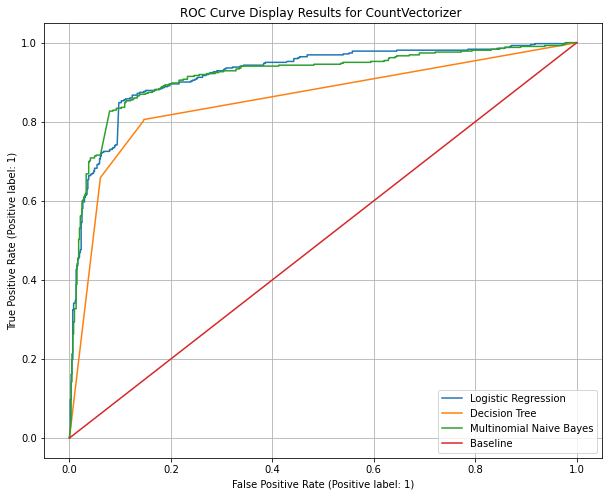

In [184]:
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(grid_lr, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_estimator(grid_dt, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_estimator(grid_nb, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Multinomial Naive Bayes')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline')
plt.title('ROC Curve Display Results for CountVectorizer ')
plt.legend()
plt.grid(True)

## ROC Plot shows Logistic Regression has the best AUC followed by  Naive Bayes 

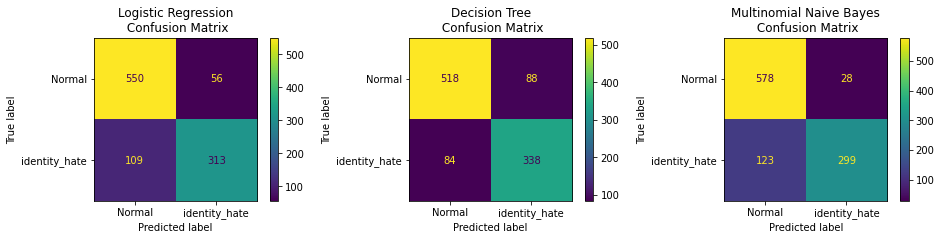

In [185]:
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, grid_lr.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, grid_dt.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, grid_nb.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('Decision Tree\n Confusion Matrix')
ax[2].set_title('Multinomial Naive Bayes\n Confusion Matrix')
plt.show()

## TF-IDF 


In [186]:
#Define Parameters

params_tfidf = {'tfidf__max_features': [100, 500, 1000, 2000],
         'tfidf__stop_words': ['english', None]}

In [187]:
#Logistic Regression
tfidf_pipe_lr = Pipeline([('tfidf', TfidfVectorizer()),
                       ('lgr', LogisticRegression())])
grid_lr_tfidf = GridSearchCV(tfidf_pipe_lr, param_grid=params_tfidf)
grid_lr_tfidf.fit(X_train['processed_text'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lgr', LogisticRegression())]),
             param_grid={'tfidf__max_features': [100, 500, 1000, 2000],
                         'tfidf__stop_words': ['english', None]})

In [188]:
lr_test_acc_tfidf = grid_lr_tfidf.score(X_test['processed_text'], y_test)
lr_train_acc_tfidf = grid_lr_tfidf.score(X_train['processed_text'], y_train)
lr_best_params_tfidf = grid_lr_tfidf.best_params_
lr_train_time_tfidf  = np.sum(grid_lr_tfidf.cv_results_["mean_fit_time"])

In [189]:
print(f'LR Train Accuracy - ',lr_train_acc_tfidf )
print(f'LR Train Time - ',lr_train_time_tfidf )
print(f'LR Test Accuracy - ',lr_test_acc_tfidf )
print(f'LR Best params - ',lr_best_params_tfidf )

LR Train Accuracy -  0.9282933160285529
LR Train Time -  1.0268941402435303
LR Test Accuracy -  0.8871595330739299
LR Best params -  {'tfidf__max_features': 2000, 'tfidf__stop_words': None}


In [190]:
#Naive Bayes
tfidf_pipe_nb = Pipeline([('tfidf',TfidfVectorizer()),('nb',MultinomialNB())])
grid_nb_tfidf = GridSearchCV(tfidf_pipe_nb,param_grid=params_tfidf)
grid_nb_tfidf.fit(X_train['processed_text'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tfidf__max_features': [100, 500, 1000, 2000],
                         'tfidf__stop_words': ['english', None]})

In [191]:
nb_test_acc_tfidf = grid_nb_tfidf.score(X_test['processed_text'], y_test)
nb_train_acc_tfidf = grid_nb_tfidf.score(X_train['processed_text'], y_train)
nb_best_params_tfidf = grid_nb_tfidf.best_params_
nb_train_time_tfidf  = np.sum(grid_nb_tfidf.cv_results_["mean_fit_time"])

In [192]:
print(f'NB Train Accuracy - ',nb_train_acc_tfidf )
print(f'NB Train Time - ',nb_train_time_tfidf )
print(f'NB Test Accuracy - ',nb_test_acc_tfidf )
print(f'NB Best params - ',nb_best_params_tfidf )

NB Train Accuracy -  0.8942245295262816
NB Train Time -  0.8430394172668457
NB Test Accuracy -  0.8647859922178989
NB Best params -  {'tfidf__max_features': 2000, 'tfidf__stop_words': 'english'}


In [193]:
#Decision Tree
tfidf_pipe_dt = Pipeline([('tfidf',TfidfVectorizer()),('dt',DecisionTreeClassifier(random_state=42))])
grid_dt_tfidf = GridSearchCV(tfidf_pipe_dt,param_grid=params_tfidf)
grid_dt_tfidf.fit(X_train['processed_text'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tfidf__max_features': [100, 500, 1000, 2000],
                         'tfidf__stop_words': ['english', None]})

In [194]:
dt_test_acc_tfidf = grid_dt_tfidf.score(X_test['processed_text'], y_test)
dt_train_acc_tfidf = grid_dt_tfidf.score(X_train['processed_text'], y_train)
dt_best_params_tfidf = grid_dt_tfidf.best_params_
dt_train_time_tfidf  = np.sum(grid_dt_tfidf.cv_results_["mean_fit_time"])

In [195]:
print(f'DT Train Accuracy - ',dt_train_acc_tfidf )
print(f'DT Train Time - ',dt_train_time_tfidf )
print(f'DT Test Accuracy - ',dt_test_acc_tfidf )
print(f'DT Best params - ',dt_best_params_tfidf )

DT Train Accuracy -  0.9837767683322518
DT Train Time -  1.718893575668335
DT Test Accuracy -  0.8268482490272373
DT Best params -  {'tfidf__max_features': 1000, 'tfidf__stop_words': 'english'}


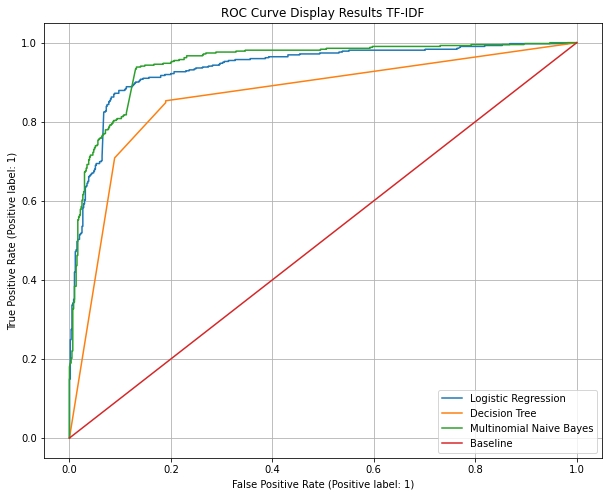

In [196]:
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(grid_lr_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_estimator(grid_dt_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_estimator(grid_nb_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Multinomial Naive Bayes')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline')
plt.title('ROC Curve Display Results TF-IDF')
plt.legend()
plt.grid(True)

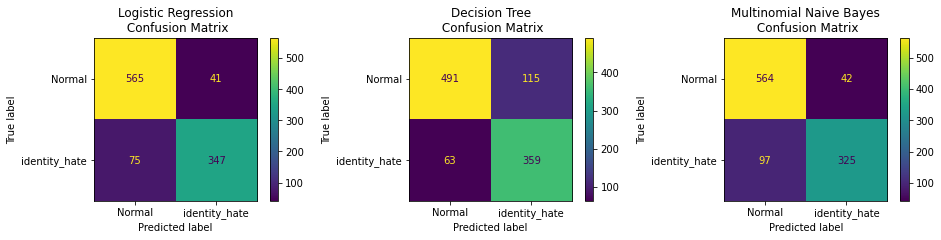

In [197]:
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, grid_lr_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, grid_dt_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, grid_nb_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('Decision Tree\n Confusion Matrix')
ax[2].set_title('Multinomial Naive Bayes\n Confusion Matrix')
plt.show()

In [198]:
# Original Text Results
pd.set_option('display.max_colwidth',None)
pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes','Logistic', 'Decision Tree', 'Bayes'], 
              'preprocessor': ['CountVectorizer', 'CountVectorizer', 'CountVectorizer','TfidfVectorizer','TfidfVectorizer','TfidfVectorizer'],
             'best_params': [lr_best_params, dt_best_params, nb_best_params,lr_best_params_tfidf,dt_best_params_tfidf,nb_best_params_tfidf],
              'best_time': [lr_train_time,dt_train_time,nb_train_time,lr_train_time_tfidf,dt_train_time_tfidf,nb_train_time_tfidf],
             'best_score': [lr_test_acc,dt_test_acc,nb_test_acc,lr_test_acc_tfidf,dt_test_acc_tfidf,nb_test_acc_tfidf]}).set_index('model')


,preprocessor,best_params,best_time,best_score
model,,,,
Logistic,CountVectorizer,"{'cvect__max_features': 2000, 'cvect__stop_words': None}",1.269634,0.839494
Decision Tree,CountVectorizer,"{'cvect__max_features': 2000, 'cvect__stop_words': 'english'}",1.276754,0.832685
Bayes,CountVectorizer,"{'cvect__max_features': 2000, 'cvect__stop_words': 'english'}",0.819695,0.853113
Logistic,TfidfVectorizer,"{'tfidf__max_features': 2000, 'tfidf__stop_words': None}",1.026894,0.887160
Decision Tree,TfidfVectorizer,"{'tfidf__max_features': 1000, 'tfidf__stop_words': 'english'}",1.718894,0.826848
Bayes,TfidfVectorizer,"{'tfidf__max_features': 2000, 'tfidf__stop_words': 'english'}",0.843039,0.864786


## Stemmed Data - Model Fitting

In [199]:
params = {'cvect__max_features': [100, 500, 1000, 2000],
         'cvect__stop_words': ['english', None]}
#Logistic Regression with CountVectorizer
vect_pipe_lr = Pipeline([('cvect', CountVectorizer()),
                       ('lgr', LogisticRegression())])
grid_lr = GridSearchCV(vect_pipe_lr, param_grid=params)
grid_lr.fit(X_train['txt_stem'], y_train)

lr_test_acc = grid_lr.score(X_test['txt_stem'], y_test)
lr_train_acc = grid_lr.score(X_train['txt_stem'], y_train)
lr_best_params = grid_lr.best_params_
lr_train_time  = np.sum(grid_lr.cv_results_["mean_fit_time"])

print(f'LR Train Accuracy - ',lr_train_acc )
print(f'LR Train Time - ',lr_train_time )
print(f'LR Test Accuracy - ',lr_test_acc )
print(f'LR Best params - ',lr_best_params )

LR Train Accuracy -  0.9402985074626866
LR Train Time -  1.2316683769226076
LR Test Accuracy -  0.8560311284046692
LR Best params -  {'cvect__max_features': 2000, 'cvect__stop_words': None}


In [200]:
#Naive Bayes with CountVectorizerv
vect_pipe_nb = Pipeline([('cvect',CountVectorizer()),('nb',MultinomialNB())])
grid_nb = GridSearchCV(vect_pipe_nb,param_grid=params)
grid_nb.fit(X_train['txt_stem'], y_train)

nb_test_acc = grid_nb.score(X_test['txt_stem'], y_test)
nb_train_acc = grid_nb.score(X_train['txt_stem'], y_train)
nb_best_params = grid_nb.best_params_
nb_train_time  = np.sum(grid_nb.cv_results_["mean_fit_time"])

print(f'NB Train Accuracy - ',nb_train_acc )
print(f'NB Train Time - ',nb_train_time )
print(f'NB Test Accuracy - ',nb_test_acc )
print(f'NB Best params - ',nb_best_params )

NB Train Accuracy -  0.8776768332251784
NB Train Time -  0.7643287181854248
NB Test Accuracy -  0.8540856031128404
NB Best params -  {'cvect__max_features': 2000, 'cvect__stop_words': 'english'}


In [201]:
#Decision Tree with CountVectorizer
vect_pipe_dt = Pipeline([('cvect',CountVectorizer()),('dt',DecisionTreeClassifier(random_state=42))])
grid_dt = GridSearchCV(vect_pipe_dt,param_grid=params)
grid_dt.fit(X_train['txt_stem'], y_train)

dt_test_acc = grid_dt.score(X_test['txt_stem'], y_test)
dt_train_acc = grid_dt.score(X_train['txt_stem'], y_train)
dt_best_params = grid_dt.best_params_
dt_train_time  = np.sum(grid_dt.cv_results_["mean_fit_time"])

print(f'DT Train Accuracy - ',dt_train_acc )
print(f'DT Train Time - ',dt_train_time )
print(f'DT Test Accuracy - ',dt_test_acc )
print(f'DT Best params - ',dt_best_params )

DT Train Accuracy -  0.9931862426995457
DT Train Time -  1.1963805198669435
DT Test Accuracy -  0.8229571984435797
DT Best params -  {'cvect__max_features': 2000, 'cvect__stop_words': 'english'}


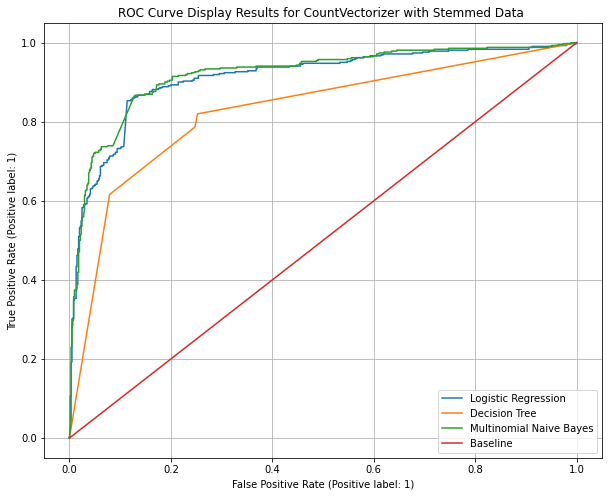

In [202]:
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(grid_lr, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_estimator(grid_dt, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_estimator(grid_nb, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Multinomial Naive Bayes')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline')
plt.title('ROC Curve Display Results for CountVectorizer with Stemmed Data ')
plt.legend()
plt.grid(True)

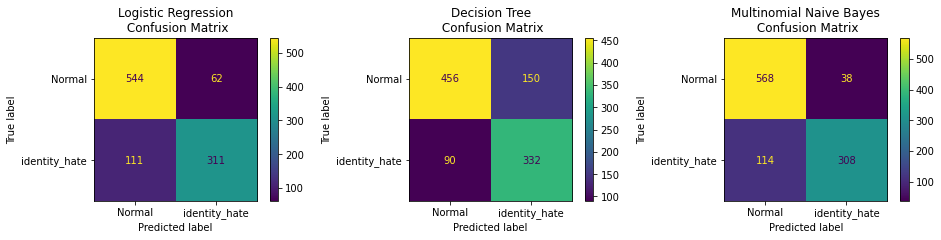

In [203]:
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, grid_lr.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, grid_dt.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, grid_nb.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('Decision Tree\n Confusion Matrix')
ax[2].set_title('Multinomial Naive Bayes\n Confusion Matrix')
plt.show()

In [204]:
#Logistic Regression with tfidf
tfidf_pipe_lr = Pipeline([('tfidf', TfidfVectorizer()),
                       ('lgr', LogisticRegression())])
grid_lr_tfidf = GridSearchCV(tfidf_pipe_lr, param_grid=params_tfidf)
grid_lr_tfidf.fit(X_train['txt_stem'], y_train)

lr_test_acc_tfidf = grid_lr_tfidf.score(X_test['txt_stem'], y_test)
lr_train_acc_tfidf = grid_lr_tfidf.score(X_train['txt_stem'], y_train)
lr_best_params_tfidf = grid_lr_tfidf.best_params_
lr_train_time_tfidf  = np.sum(grid_lr_tfidf.cv_results_["mean_fit_time"])

print(f'LR Train Accuracy - ',lr_train_acc_tfidf )
print(f'LR Train Time - ',lr_train_time_tfidf )
print(f'LR Test Accuracy - ',lr_test_acc_tfidf )
print(f'LR Best params - ',lr_best_params_tfidf )

LR Train Accuracy -  0.9123945489941596
LR Train Time -  0.931857967376709
LR Test Accuracy -  0.8881322957198443
LR Best params -  {'tfidf__max_features': 500, 'tfidf__stop_words': None}


In [205]:
#Naive Bayes with tfidf
tfidf_pipe_nb = Pipeline([('tfidf',TfidfVectorizer()),('nb',MultinomialNB())])
grid_nb_tfidf = GridSearchCV(tfidf_pipe_nb,param_grid=params_tfidf)
grid_nb_tfidf.fit(X_train['txt_stem'], y_train)

nb_test_acc_tfidf = grid_nb_tfidf.score(X_test['txt_stem'], y_test)
nb_train_acc_tfidf = grid_nb_tfidf.score(X_train['txt_stem'], y_train)
nb_best_params_tfidf = grid_nb_tfidf.best_params_
nb_train_time_tfidf  = np.sum(grid_nb_tfidf.cv_results_["mean_fit_time"])

print(f'NB Train Accuracy - ',nb_train_acc_tfidf )
print(f'NB Train Time - ',nb_train_time_tfidf )
print(f'NB Test Accuracy - ',nb_test_acc_tfidf )
print(f'NB Best params - ',nb_best_params_tfidf )

NB Train Accuracy -  0.8971447112264763
NB Train Time -  0.7764788627624513
NB Test Accuracy -  0.867704280155642
NB Best params -  {'tfidf__max_features': 2000, 'tfidf__stop_words': 'english'}


In [206]:
#Decision Tree with tfidf

tfidf_pipe_dt = Pipeline([('tfidf',TfidfVectorizer()),('dt',DecisionTreeClassifier(random_state=42))])
grid_dt_tfidf = GridSearchCV(tfidf_pipe_dt,param_grid=params_tfidf)
grid_dt_tfidf.fit(X_train['txt_stem'], y_train)

dt_test_acc_tfidf = grid_dt_tfidf.score(X_test['txt_stem'], y_test)
dt_train_acc_tfidf = grid_dt_tfidf.score(X_train['txt_stem'], y_train)
dt_best_params_tfidf = grid_dt_tfidf.best_params_
dt_train_time_tfidf  = np.sum(grid_dt_tfidf.cv_results_["mean_fit_time"])

print(f'DT Train Accuracy - ',dt_train_acc_tfidf )
print(f'DT Train Time - ',dt_train_time_tfidf )
print(f'DT Test Accuracy - ',dt_test_acc_tfidf )
print(f'DT Best params - ',dt_best_params_tfidf )

DT Train Accuracy -  0.9883192731992213
DT Train Time -  1.588392400741577
DT Test Accuracy -  0.8394941634241245
DT Best params -  {'tfidf__max_features': 1000, 'tfidf__stop_words': 'english'}


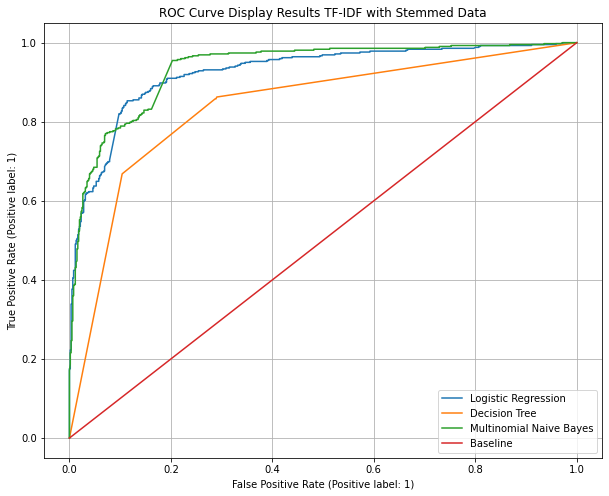

In [207]:
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(grid_lr_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_estimator(grid_dt_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_estimator(grid_nb_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Multinomial Naive Bayes')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline')
plt.title('ROC Curve Display Results TF-IDF with Stemmed Data')
plt.legend()
plt.grid(True)

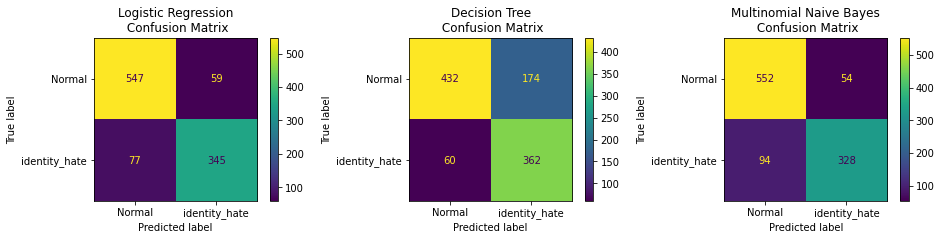

In [208]:
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, grid_lr_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, grid_dt_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, grid_nb_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('Decision Tree\n Confusion Matrix')
ax[2].set_title('Multinomial Naive Bayes\n Confusion Matrix')
plt.show()

In [209]:
# Stemmed Data Results
pd.set_option('display.max_colwidth',None)
pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes','Logistic', 'Decision Tree', 'Bayes'], 
              'preprocessor': ['CountVectorizer', 'CountVectorizer', 'CountVectorizer','TfidfVectorizer','TfidfVectorizer','TfidfVectorizer'],
             'best_params': [lr_best_params, dt_best_params, nb_best_params,lr_best_params_tfidf,dt_best_params_tfidf,nb_best_params_tfidf],
              'best_time': [lr_train_time,dt_train_time,nb_train_time,lr_train_time_tfidf,dt_train_time_tfidf,nb_train_time_tfidf],
             'best_score': [lr_test_acc,dt_test_acc,nb_test_acc,lr_test_acc_tfidf,dt_test_acc_tfidf,nb_test_acc_tfidf]}).set_index('model')



,preprocessor,best_params,best_time,best_score
model,,,,
Logistic,CountVectorizer,"{'cvect__max_features': 2000, 'cvect__stop_words': None}",1.231668,0.856031
Decision Tree,CountVectorizer,"{'cvect__max_features': 2000, 'cvect__stop_words': 'english'}",1.196381,0.822957
Bayes,CountVectorizer,"{'cvect__max_features': 2000, 'cvect__stop_words': 'english'}",0.764329,0.854086
Logistic,TfidfVectorizer,"{'tfidf__max_features': 500, 'tfidf__stop_words': None}",0.931858,0.888132
Decision Tree,TfidfVectorizer,"{'tfidf__max_features': 1000, 'tfidf__stop_words': 'english'}",1.588392,0.839494
Bayes,TfidfVectorizer,"{'tfidf__max_features': 2000, 'tfidf__stop_words': 'english'}",0.776479,0.867704


## Lemmatized Data - Model Fitting

In [210]:
params = {'cvect__max_features': [100, 500, 1000, 2000],
         'cvect__stop_words': ['english', None]}
#Logistic Regression with CountVectorizer
vect_pipe_lr = Pipeline([('cvect', CountVectorizer()),
                       ('lgr', LogisticRegression())])
grid_lr = GridSearchCV(vect_pipe_lr, param_grid=params)
grid_lr.fit(X_train['txt_lemma'], y_train)

lr_test_acc = grid_lr.score(X_test['txt_lemma'], y_test)
lr_train_acc = grid_lr.score(X_train['txt_lemma'], y_train)
lr_best_params = grid_lr.best_params_
lr_train_time  = np.sum(grid_lr.cv_results_["mean_fit_time"])

print(f'LR Train Accuracy - ',lr_train_acc )
print(f'LR Train Time - ',lr_train_time )
print(f'LR Test Accuracy - ',lr_test_acc )
print(f'LR Best params - ',lr_best_params )

LR Train Accuracy -  0.9354315379623621
LR Train Time -  1.1601258754730226
LR Test Accuracy -  0.8443579766536965
LR Best params -  {'cvect__max_features': 2000, 'cvect__stop_words': None}


In [211]:
#Naive Bayes with CountVectorizer
vect_pipe_nb = Pipeline([('cvect',CountVectorizer()),('nb',MultinomialNB())])
grid_nb = GridSearchCV(vect_pipe_nb,param_grid=params)
grid_nb.fit(X_train['txt_lemma'], y_train)

nb_test_acc = grid_nb.score(X_test['txt_lemma'], y_test)
nb_train_acc = grid_nb.score(X_train['txt_lemma'], y_train)
nb_best_params = grid_nb.best_params_
nb_train_time  = np.sum(grid_nb.cv_results_["mean_fit_time"])

print(f'NB Train Accuracy - ',nb_train_acc )
print(f'NB Train Time - ',nb_train_time )
print(f'NB Test Accuracy - ',nb_test_acc )
print(f'NB Best params - ',nb_best_params )

NB Train Accuracy -  0.8786502271252433
NB Train Time -  0.7924050331115722
NB Test Accuracy -  0.8599221789883269
NB Best params -  {'cvect__max_features': 2000, 'cvect__stop_words': 'english'}


In [212]:
#Decision Tree with CountVectorizer
vect_pipe_dt = Pipeline([('cvect',CountVectorizer()),('dt',DecisionTreeClassifier(random_state=42))])
grid_dt = GridSearchCV(vect_pipe_dt,param_grid=params)
grid_dt.fit(X_train['txt_lemma'], y_train)

dt_test_acc = grid_dt.score(X_test['txt_lemma'], y_test)
dt_train_acc = grid_dt.score(X_train['txt_lemma'], y_train)
dt_best_params = grid_dt.best_params_
dt_train_time  = np.sum(grid_dt.cv_results_["mean_fit_time"])

print(f'DT Train Accuracy - ',dt_train_acc )
print(f'DT Train Time - ',dt_train_time )
print(f'DT Test Accuracy - ',dt_test_acc )
print(f'DT Best params - ',dt_best_params )

DT Train Accuracy -  0.9857235561323816
DT Train Time -  1.160744047164917
DT Test Accuracy -  0.8297665369649806
DT Best params -  {'cvect__max_features': 1000, 'cvect__stop_words': 'english'}


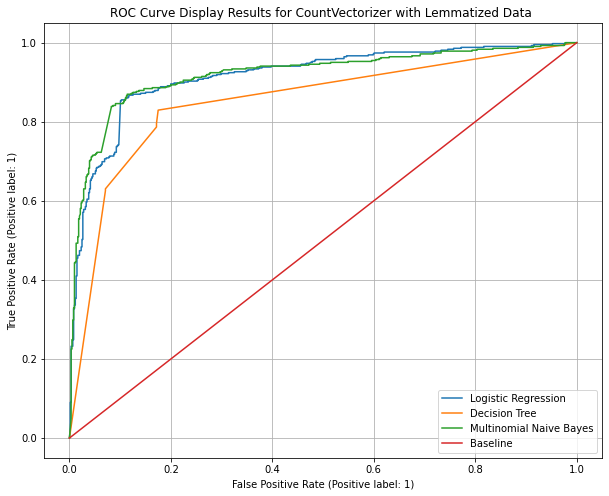

In [213]:
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(grid_lr, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_estimator(grid_dt, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_estimator(grid_nb, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Multinomial Naive Bayes')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline')
plt.title('ROC Curve Display Results for CountVectorizer with Lemmatized Data ')
plt.legend()
plt.grid(True)

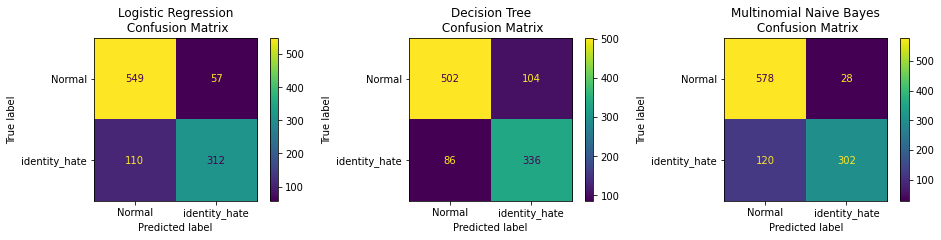

In [214]:
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, grid_lr.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, grid_dt.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, grid_nb.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('Decision Tree\n Confusion Matrix')
ax[2].set_title('Multinomial Naive Bayes\n Confusion Matrix')
plt.show()

In [215]:
#Logistic Regression with tfidf
tfidf_pipe_lr = Pipeline([('tfidf', TfidfVectorizer()),
                       ('lgr', LogisticRegression())])
grid_lr_tfidf = GridSearchCV(tfidf_pipe_lr, param_grid=params_tfidf)
grid_lr_tfidf.fit(X_train['txt_lemma'], y_train)

lr_test_acc_tfidf = grid_lr_tfidf.score(X_test['txt_lemma'], y_test)
lr_train_acc_tfidf = grid_lr_tfidf.score(X_train['txt_lemma'], y_train)
lr_best_params_tfidf = grid_lr_tfidf.best_params_
lr_train_time_tfidf  = np.sum(grid_lr_tfidf.cv_results_["mean_fit_time"])

print(f'LR Train Accuracy - ',lr_train_acc_tfidf )
print(f'LR Train Time - ',lr_train_time_tfidf )
print(f'LR Test Accuracy - ',lr_test_acc_tfidf )
print(f'LR Best params - ',lr_best_params_tfidf )

LR Train Accuracy -  0.9065541855937703
LR Train Time -  0.9366128444671631
LR Test Accuracy -  0.8715953307392996
LR Best params -  {'tfidf__max_features': 500, 'tfidf__stop_words': None}


In [216]:
#Naive Bayes with tfidf
tfidf_pipe_nb = Pipeline([('tfidf',TfidfVectorizer()),('nb',MultinomialNB())])
grid_nb_tfidf = GridSearchCV(tfidf_pipe_nb,param_grid=params_tfidf)
grid_nb_tfidf.fit(X_train['txt_lemma'], y_train)

nb_test_acc_tfidf = grid_nb_tfidf.score(X_test['txt_lemma'], y_test)
nb_train_acc_tfidf = grid_nb_tfidf.score(X_train['txt_lemma'], y_train)
nb_best_params_tfidf = grid_nb_tfidf.best_params_
nb_train_time_tfidf  = np.sum(grid_nb_tfidf.cv_results_["mean_fit_time"])

print(f'NB Train Accuracy - ',nb_train_acc_tfidf )
print(f'NB Train Time - ',nb_train_time_tfidf )
print(f'NB Test Accuracy - ',nb_test_acc_tfidf )
print(f'NB Best params - ',nb_best_params_tfidf )

NB Train Accuracy -  0.8977936404931862
NB Train Time -  0.8597823143005371
NB Test Accuracy -  0.872568093385214
NB Best params -  {'tfidf__max_features': 2000, 'tfidf__stop_words': 'english'}


In [217]:
## Decision Tree with tfidf
tfidf_pipe_dt = Pipeline([('tfidf',TfidfVectorizer()),('dt',DecisionTreeClassifier(random_state=42))])
grid_dt_tfidf = GridSearchCV(tfidf_pipe_dt,param_grid=params_tfidf)
grid_dt_tfidf.fit(X_train['txt_lemma'], y_train)

dt_test_acc_tfidf = grid_dt_tfidf.score(X_test['txt_lemma'], y_test)
dt_train_acc_tfidf = grid_dt_tfidf.score(X_train['txt_lemma'], y_train)
dt_best_params_tfidf = grid_dt_tfidf.best_params_
dt_train_time_tfidf  = np.sum(grid_dt_tfidf.cv_results_["mean_fit_time"])

print(f'DT Train Accuracy - ',dt_train_acc_tfidf )
print(f'DT Train Time - ',dt_train_time_tfidf )
print(f'DT Test Accuracy - ',dt_test_acc_tfidf )
print(f'DT Best params - ',dt_best_params_tfidf )

DT Train Accuracy -  0.9853990914990266
DT Train Time -  1.6557682991027831
DT Test Accuracy -  0.8550583657587548
DT Best params -  {'tfidf__max_features': 1000, 'tfidf__stop_words': 'english'}


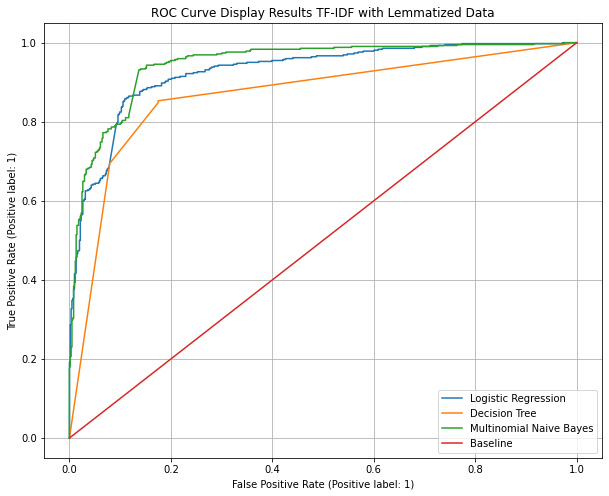

In [218]:
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(grid_lr_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_estimator(grid_dt_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Decision Tree')
RocCurveDisplay.from_estimator(grid_nb_tfidf, X_test['processed_text'], y_test, pos_label = 1, ax = ax, label = 'Multinomial Naive Bayes')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'Baseline')
plt.title('ROC Curve Display Results TF-IDF with Lemmatized Data')
plt.legend()
plt.grid(True)

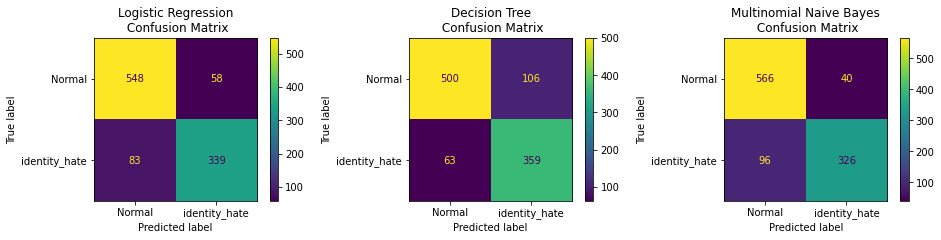

In [219]:
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, grid_lr_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, grid_dt_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, grid_nb_tfidf.predict(X_test['processed_text']), display_labels = ['Normal', 'identity_hate'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Logistic Regression\n Confusion Matrix')
ax[1].set_title('Decision Tree\n Confusion Matrix')
ax[2].set_title('Multinomial Naive Bayes\n Confusion Matrix')
plt.show()

In [221]:
# Lemmatized Data Results
pd.set_option('display.max_colwidth',None)
pd.DataFrame({'model': ['Logistic', 'Decision Tree', 'Bayes','Logistic', 'Decision Tree', 'Bayes'], 
              'preprocessor': ['CountVectorizer', 'CountVectorizer', 'CountVectorizer','TfidfVectorizer','TfidfVectorizer','TfidfVectorizer'],
             'best_params': [lr_best_params, dt_best_params, nb_best_params,lr_best_params_tfidf,dt_best_params_tfidf,nb_best_params_tfidf],
              'best_time': [lr_train_time,dt_train_time,nb_train_time,lr_train_time_tfidf,dt_train_time_tfidf,nb_train_time_tfidf],
             'best_score': [lr_test_acc,dt_test_acc,nb_test_acc,lr_test_acc_tfidf,dt_test_acc_tfidf,nb_test_acc_tfidf]}).set_index('model')


,preprocessor,best_params,best_time,best_score
model,,,,
Logistic,CountVectorizer,"{'cvect__max_features': 2000, 'cvect__stop_words': None}",1.160126,0.844358
Decision Tree,CountVectorizer,"{'cvect__max_features': 1000, 'cvect__stop_words': 'english'}",1.160744,0.829767
Bayes,CountVectorizer,"{'cvect__max_features': 2000, 'cvect__stop_words': 'english'}",0.792405,0.859922
Logistic,TfidfVectorizer,"{'tfidf__max_features': 500, 'tfidf__stop_words': None}",0.936613,0.871595
Decision Tree,TfidfVectorizer,"{'tfidf__max_features': 1000, 'tfidf__stop_words': 'english'}",1.655768,0.855058
Bayes,TfidfVectorizer,"{'tfidf__max_features': 2000, 'tfidf__stop_words': 'english'}",0.859782,0.872568


## Testing the model on real world data
### I have taken examples from Live Customer interacction's with ChatBot application.
### Created two evaluation dataset
#### 1 - This has normal utterances Non identity_hate

#### 2 - This has utterances which were identified as egregious and fall under identity_hate class

### The dataset was manually tagged by our customer care representatives who interact with customers on a daily basis

In [222]:
# First loading the dataset with Normal utterances
eval_normal = pd.read_csv('data/evaluate_normal_utterances.csv')

In [223]:
eval_normal.head(3)

,Text,identity_hate
0,I need to cancel my last order! I dont know what I did but I dont want it I placed a order for a different item,0
1,How do I cancel an automatic payment,0
2,How do I cancel the transfer,0


In [224]:
# Now loading the dataset with Egregious utterances
eval_egregious = pd.read_csv('data/evaluate_egregious_utterances.csv')

In [225]:
eval_egregious.head(3)

,Text,identity_hate
0,remove the fucking cunt put a fucking person on the phone with the fuck no stop talking to a personal fitch,1
1,you fucking cunt answered get on the fucking line,1
2,i received an e_mail from you whore @side_speech@ @side_speech@,1


In [226]:
# Appending the two
df2 = eval_egregious
df2 = df2.append(eval_normal)

In [227]:
y_real_test = df2['identity_hate']
X_real_test = df2.drop('identity_hate',axis=1)

### Logistic Regression with TfidfVectorizer on non stemmed and Lemmatized data gave best score of 0.887160, using the same on rela wprld data set

In [228]:
params_tfidf = {'tfidf__max_features': [100, 500, 1000, 2000],
         'tfidf__stop_words': ['english', None]}
#Logistic Regression
tfidf_pipe_lr = Pipeline([('tfidf', TfidfVectorizer()),
                       ('lgr', LogisticRegression())])
grid_lr_tfidf = GridSearchCV(tfidf_pipe_lr, param_grid=params_tfidf)
grid_lr_tfidf.fit(X_train['processed_text'], y_train)
grid_lr_tfidf.score(X_real_test['Text'],y_real_test)

0.7875

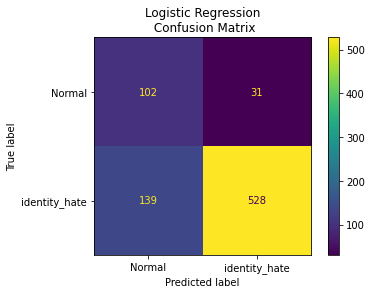

In [229]:
plt.figsize = (16, 3)

ConfusionMatrixDisplay.from_predictions(y_real_test, grid_lr_tfidf.predict(X_real_test['Text']), display_labels = ['Normal', 'identity_hate'])
#ax[0].grid(False)
plt.title('Logistic Regression\n Confusion Matrix')
plt.show()

## For Logistic Regression with TfidfVectorizer, overall accuracy on the real world data  0.7875, on training set our accuracy was : 0.88716
